#### Magic Commands
Magic commands (those that start with `%`) are commands that modify a configuration of Jupyter Notebooks. A number of magic commands are available by default (see list [here](http://ipython.readthedocs.io/en/stable/interactive/magics.html))--and many more can be added with extensions. The magic command added in this section allows `matplotlib` to display our plots directly on the browser instead of having to save them on a local file.

In [1]:
%matplotlib inline

# Exercise 3.01: Creating an active training environment
In this activity we learn to evaluate our LSTM model and to actively train it with new data.

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [26]:
import sys
sys.path.append('scripts')

In [27]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
from datetime import datetime, timedelta

In [28]:
from utilities import create_groups, split_lstm_input

In [29]:
plt.style.use('seaborn-white')

### Validation Data
On Lesson 1, we separated our Bitcoin dataset using a 90/10 split. 90% of the data was used to train `v0` of our LSTM model and 10% was left for evaluation purposes. Let's load these datasets into this session.

In [30]:
train = pd.read_csv('data/train_dataset.csv')

In [31]:
test = pd.read_csv('data/test_dataset.csv')

In [32]:
len(train), len(test)

(1309, 147)

In [33]:
train.iso_week.nunique()
test.iso_week.nunique()

21

### Re-train Model with TensorBoard
We have trained our model previously using a vanilla Keras implementation. We will now retrain that same model (loaded using `load_model()`) using the same parameters, but adding the `TensorBoard` callback. This allows us to investigate how that model is performing in near-real time.

In [34]:
def train_model(model, X, Y, epochs=100, version=0, run_number=0):
    """
    Shorthand function for training a new model.
    This function names each run of the model
    using the TensorBoard naming conventions.
    
    Parameters
    ----------
    model: Keras model instance
        Compiled Keras model.

    X, Y: np.array
        Series of observations to be used in
        the training process.
    
    epochs: int
        The number of epochs to train the
        model for.

    version: int
        Version of the model to run.
    
    run_number: int
        The number of the run. Used in case
        the same model version is run again.
    """
    model_name = 'bitcoin_lstm_v{version}_run_{run_number}'.format(version=version, 
                                                      run_number=run_number)

    tensorboard = TensorBoard(log_dir='logs\\{}'.format(model_name), profile_batch = 100000000)
    
    model_history = model.fit(
        x=X, y=Y,
        batch_size=1, epochs=5,
        verbose=0, 
        shuffle=False,
        callbacks=[tensorboard])
    
    return model_history

In [35]:
train_data = create_groups(
    train['close_point_relative_normalization'].values, 7)

In [36]:
test_data = create_groups(
    test['close_point_relative_normalization'].values, 7)

In [37]:
X_train, Y_train = split_lstm_input(train_data)

In [38]:
model = load_model('bitcoin_lstm_v0.h5')

In [39]:
X_train.shape, Y_train.shape

((1, 186, 7), (1, 7))

In [40]:
model_history = train_model(model=model, X=X_train, Y=Y_train, epochs=10, version=0, run_number=0)

### Evaluate LSTM Model
Let's evaluate how our model performed against unseen data. Our model is trained in 76 weeks to predict a following weeks--that is, a sequence of 7 days. When we started this project we divided our original dataset between a test and a validation set. We will now take that originally trained network--containing 76 weeks--and use it to predict all the 19 weeks from the validation set.

In order to do that we need a sequence of 76 weeks as the data used for predictions. To get that data in a continuous way, we combine the training and validation sets, then move a 76 window from the beginning of the series until its end - 1. We leave one at the end because that's the final target prediction that we can make.

At each one of these iterations, our LSTM model generates a 7-day prediction. We take those predictions and separate them. We then compare the predicted series with all the weeks in the validation set. We do this by computing both MSE and MAPE on that final series. 

In [41]:
combined_set = np.concatenate((train_data, test_data), axis=1)

In [42]:
combined_set.shape

(1, 208, 7)

In [43]:
evaluated_weeks = []
for i in range(0, test_data.shape[1]):
    input_series = combined_set[0:,i:i+187]

    X_test = input_series[0:,:-1].reshape(1, input_series.shape[1] - 1, 7)
    Y_test = input_series[0:,-1:][0]
    
    result = model.evaluate(x=X_test, y=Y_test, verbose=0)
    evaluated_weeks.append(result)

In [44]:
evaluated_weeks

[0.006229581777006388,
 0.0012149987742304802,
 0.010722511447966099,
 0.005208127666264772,
 0.005631786771118641,
 0.00029481417732313275,
 0.00032939924858510494,
 0.000621839368250221,
 0.02247968129813671,
 0.0007047279505059123,
 0.0003372866485733539,
 0.001999045955017209,
 0.008892335928976536,
 0.0004348762158770114,
 0.002531251171603799,
 0.0008267046068795025,
 0.010869739577174187,
 0.0015812505735084414,
 0.0003207200497854501,
 0.001779339392669499,
 0.0013833920238539577]

Text(0, 0.5, 'MSE')

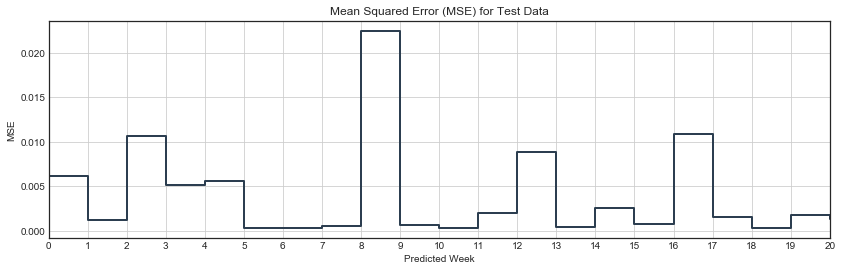

In [45]:
ax = pd.Series(evaluated_weeks).plot(drawstyle="steps-post",
                                     figsize=(14,4),
                                     linewidth=2,
                                     color='#2c3e50',
                                     grid=True,
                                     title='Mean Squared Error (MSE) for Test Data')

y = [i for i in range(0, len(evaluated_weeks))]
yint = range(min(y), math.ceil(max(y))+1)
plt.xticks(yint)

ax.set_xlabel("Predicted Week")
ax.set_ylabel("MSE")

## Interpreting the Model Results
MSE is a good loss function for our problem, but its results are difficult to interpret. We use two utility functions to facilitate the interpretation of our results: Root Mean Squared Error (`rmse()`) and Mean Absolute Error (`mape()`). We will execute these functions for both the observed and predicted series. 

### Make Predictions

Now, let's make predictions for every week of the dataset using a similar technique. Instead of calling the `evaluate()` method to compute the network's MSE, we now use the `predict()` method for making future predictions.

In [57]:
predicted_weeks = []

for i in range(0, test_data.shape[1]):
    input_series = combined_set[0:,i:i+186]
    predicted_weeks.append(model.predict(input_series))
    
    
predicted_days = []
for week in predicted_weeks:
    predicted_days += list(week[0])

Let's now create a new Pandas DataFrame with the predicted values. This will help us when plotting and manipulating data.

In [58]:
train.shape, test.shape

((1309, 6), (147, 6))

In [59]:
combined = pd.concat([train, test])

In [60]:
last_day = datetime.strptime(train['date'].max(), '%Y-%m-%d')
list_of_days = []

for days in range(1, len(predicted_days) + 1):
    D = (last_day + timedelta(days=days)).strftime('%Y-%m-%d')
    list_of_days.append(D)
print(len(list_of_days))

147


In [61]:
predicted = pd.DataFrame({
    'date': list_of_days, 
    'close_point_relative_normalization': predicted_days 
})

In [62]:
combined['date'] = combined['date'].apply(
                    lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [63]:
predicted['date'] = predicted['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [64]:
predicted.isnull().sum()

date                                  0
close_point_relative_normalization    0
dtype: int64

In [65]:
observed = combined[combined['date'] > train['date'].max()]

The graph below compares the predicted value versus the real one. 

In [66]:
def plot_two_series(A, B, variable, title):
    """
    Plots two series using the same `date` index. 
    
    Parameters
    ----------
    A, B: pd.DataFrame
        Dataframe with a `date` key and a variable
        passed in the `variable` parameter. Parameter A
        represents the "Observed" series and B the "Predicted"
        series. These will be labelled respectivelly. 
    
    variable: str
        Variable to use in plot.
    
    title: str
        Plot title.
    
    """
    plt.figure(figsize=(14,4))
    plt.xlabel('Real and predicted')

    ax1 = A.set_index('date')[variable].plot(
        linewidth=2, color='#d35400', grid=True, label='Observed', title=title)

    ax2 = B.set_index('date')[variable].plot(
        linewidth=2, color='grey', grid=True, label='Predicted')
    
    ax1.set_xlabel("Predicted Week")
    ax1.set_ylabel("Predicted Values")

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()

    plt.legend(l1+l2, loc=2)
    plt.show()

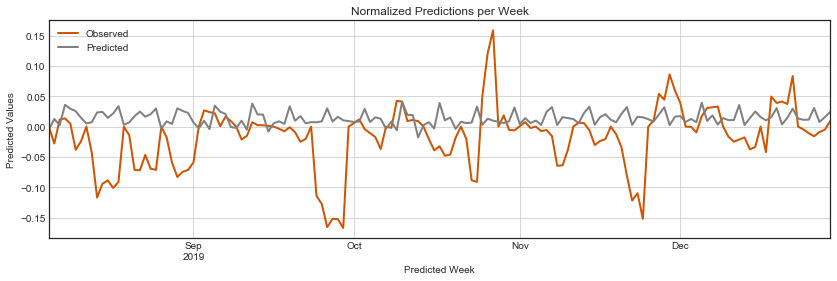

In [67]:
plot_two_series(observed, predicted, 
                variable='close_point_relative_normalization',
                title='Normalized Predictions per Week')

### De-normalized Predictions
Let's also compare the predictions with our denormalized series. 

In [68]:
predicted['iso_week'] = predicted.date.dt.year.astype('str') + '-' + predicted.date.dt.week.astype('str')

In [69]:
def denormalize(reference, series, 
                normalized_variable='close_point_relative_normalization',
                denormalized_variable='close'):
    """
    Denormalizes the values for a given series.
    
    Parameters
    ----------
    reference: pd.DataFrame
        DataFrame to use as reference. This dataframe
        contains both a week index and the USD price
        reference that we are interested on.

    series: pd.DataFrame
        DataFrame with the predicted series. The 
        DataFrame must have the same columns as the
        `reference` dataset.
    
    normalized_variable: str, default 'close_point_relative_normalization'
        Variable to use in normalization.
    
    denormalized_variable: str, `close`
        Variable to use in de-normalization.
    
    Returns
    -------
    A modified DataFrame with the new variable provided
    in `denormalized_variable` parameter.
    """

    if('iso_week' in list(series.columns)):
    
        week_values = reference[reference['iso_week'] == series['iso_week'].values[0]]
        last_value = week_values[denormalized_variable].values[0]
        series[denormalized_variable] = last_value * (series[normalized_variable] + 1)


    return series

Let's now plot the predicted timeseries versus the observed one using the `close` price values.

In [70]:
predicted_close = predicted.groupby('iso_week').apply(lambda x: denormalize(observed, x))

In [71]:
print(len(predicted_close), len(observed))

147 147


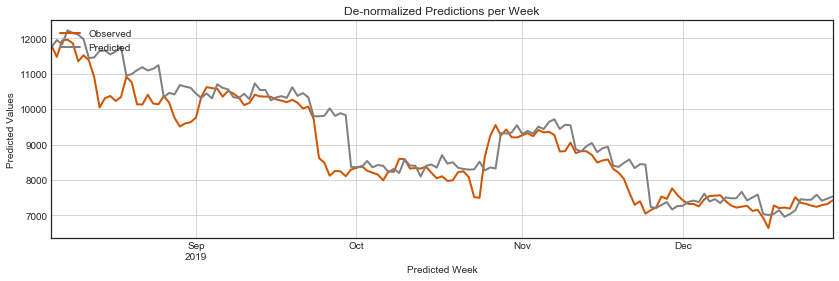

In [72]:
plot_two_series(observed, predicted_close, 
                variable='close',
                title='De-normalized Predictions per Week')

### Calculate RMSE and MAPE
After computing both timeseries we want to predict how close the predictions are to the real, observed data. We do this by using a modified version of our loss function (the Root Mean Squared Error instead of the Mean Squared Error) and add the Mean Absolute Percentage Error (MAPE) for readability.

In [46]:
from utilities import rmse, mape

In [320]:
print('Normalized RMSE: {:.2f}'.format(
    rmse(observed['close_point_relative_normalization'][:-3], 
         predicted_close['close_point_relative_normalization'])))

Normalized RMSE: 0.06


In [321]:
print('De-normalized RMSE: ${:.1f} USD'.format(
    rmse(observed['close'][:-3], 
         predicted_close['close'])))

print('De-normalized MAPE: {:.1f}%'.format(
    mape(observed['close'][:-3], 
         predicted_close['close'])))

De-normalized RMSE: $596.6 USD
De-normalized MAPE: 4.7%


------